# COSMOS master catalogue
## Convert COSMOS2020 to help format for HELP DR2 alpha

This catalogue comes from `dmu1_COSMOS2020`. We here process the COSMOS2020 catalogue to the HELP format so that it can be merged in with the full area HELP cosmos data sets.



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
1407877 (Mon Feb 4 12:56:29 2019 +0000)
This notebook was executed on: 
2021-01-15 18:16:04.635334


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux, flux_to_mag

/Users/rs548/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/rs548/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/rs548/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/rs548/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  sel

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = '/Volumes/Raph500/COSMOS2020'
OUT_DIR = '~/COSMOS2020'
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "cosmos_ra"
DEC_COL = "cosmos_dec"

## I - Column selection

In [4]:
bands = OrderedDict({
    'UVISTA_Ks': 'vista_ks',
    'UVISTA_Y': 'vista_y',
    'UVISTA_H': 'vista_h',
    'UVISTA_J': 'vista_j',

    #CFHT Megacam
    'CFHT_u': 'megacam_u',
    #SUBARU Suprime
    'SC_B': 'suprime_b',
    'SC_V': 'suprime_v',
    'SC_ip': 'suprime_ip',
    'SC_rp': 'suprime_rc',
    'SC_zp': 'suprime_zp',
    'SC_zpp': 'suprime_zpp',
    'SC_IA484': 'suprime_ia484',
    'SC_IA527': 'suprime_ia527',
    'SC_IA624': 'suprime_ia624',
    'SC_IA679': 'suprime_ia679',
    'SC_IA738': 'suprime_ia738',
    'SC_IA767': 'suprime_ia767',
    'SC_IB427': 'suprime_ib427',
    'SC_IB464': 'suprime_ib464',
    'SC_IB505': 'suprime_ib505',
    'SC_IB574': 'suprime_ib574',
    'SC_IB709': 'suprime_ib709',
    'SC_IB827': 'suprime_ib827',
    'SC_NB711': 'suprime_nb711',
    'SC_NB816': 'suprime_nb816',
    #CFHT WIRCAM
    #'hw': 'wircam_h',
    #'ksw': 'wircam_ks',
    #SUBARU HSC
    'HSC_g': 'suprime_g',
    'HSC_r': 'suprime_r',
    'HSC_i': 'suprime_i',
    'HSC_z': 'suprime_z',
    'HSC_y': 'suprime_y',
    #Spitzer IRAC
    'SPLASH_CH1': 'irac_i1', #'irac_i1'???
    'SPLASH_CH2': 'irac_i2', # #irac_i2
    'SPLASH_CH3': 'irac_i3', # #irac_i1
    'SPLASH_CH4': 'irac_i4', # #irac_i4
})

In [5]:
imported_columns = OrderedDict({
    #'help_id': 'help_id', #COSMOS 2020 hasn't had help ids added
    'ID': 'cosmos_id',
    'ALPHA_J2000': 'cosmos_ra',
    'DELTA_J2000': 'cosmos_dec',
    #'class': 'cosmos_stellarity', #No stellarity in COSMOS 2020?
})

for band in list(bands):
    if 'SPLASH' not in band:
        imported_columns.update({band + '_MAG_AUTO': 'm_cosmos-' + bands[band]})
        imported_columns.update({band + '_MAGERR_AUTO': 'merr_cosmos-' + bands[band]})
        imported_columns.update({band + '_FLUX_APER2': 'f_ap_cosmos-' + bands[band]})
        imported_columns.update({band + '_FLUXERR_APER2': 'ferr_ap_cosmos-' + bands[band]})
    elif 'SPLASH' in band:
        imported_columns.update({band + '_FLUX': 'f_cosmos-' + bands[band]})
        imported_columns.update({band + '_FLUXERR': 'ferr_cosmos-' + bands[band]})
        imported_columns.update({band + '_MAG': 'm_cosmos-' + bands[band]})
        imported_columns.update({band + '_MAGERR': 'merr_cosmos-' + bands[band]})        
        


In [6]:

catalogue = Table.read(
    OUT_DIR+"cosmos2020.calet.org/PHOTOMETRY/"+
    "COSMOS2020_CLASSIC_v1.8_formatted.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2015 #Various epochs

# Clean table metadata
catalogue.meta = None

In [7]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    #print(col)
    if 'irac' in col:
        if col.startswith('f_'):
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
            mask = ( (catalogue[col] < -90.)
                   | (catalogue[col.replace('f_', 'ferr_')] < -90.)
                   )
            catalogue[col][mask] = np.nan
            catalogue[col.replace('f_', 'ferr_')][mask] = np.nan
        if col.startswith('m_'):
           
            mask = ( (catalogue[col] < -90.)
                   | (catalogue[col.replace('m_', 'merr_')] < -90.)
                   )
            catalogue[col][mask] = np.nan
            catalogue[col.replace('m_', 'merr_')][mask] = np.nan
        continue
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        
        
        mask = (catalogue[col] > 90.) | (catalogue[col] < 0.)
        catalogue[col][mask] = np.nan
        catalogue[errcol][mask]  = np.nan     
        
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
    if col.startswith('f_'):
        errcol = "ferr{}".format(col[1:])
        
        mask = (np.isclose(catalogue[col] , -99.9) )
        catalogue[col][mask] = np.nan
        catalogue[errcol][mask] = np.nan 
        
        mag, error = flux_to_mag(np.array(catalogue[col])* 1.e-6, np.array(catalogue[errcol])* 1.e-6)
        # Mags added
        catalogue.add_column(Column(mag , name="m{}".format(col[1:])))
        catalogue.add_column(Column(error , name="m{}".format(errcol[1:])))


/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:77: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6


In [8]:
catalogue[:10].show_in_notebook()

idx,cosmos_id,cosmos_ra,cosmos_dec,m_cosmos-vista_ks,merr_cosmos-vista_ks,f_ap_cosmos-vista_ks,ferr_ap_cosmos-vista_ks,m_cosmos-vista_y,merr_cosmos-vista_y,f_ap_cosmos-vista_y,ferr_ap_cosmos-vista_y,m_cosmos-vista_h,merr_cosmos-vista_h,f_ap_cosmos-vista_h,ferr_ap_cosmos-vista_h,m_cosmos-vista_j,merr_cosmos-vista_j,f_ap_cosmos-vista_j,ferr_ap_cosmos-vista_j,m_cosmos-megacam_u,merr_cosmos-megacam_u,f_ap_cosmos-megacam_u,ferr_ap_cosmos-megacam_u,m_cosmos-suprime_b,merr_cosmos-suprime_b,f_ap_cosmos-suprime_b,ferr_ap_cosmos-suprime_b,m_cosmos-suprime_v,merr_cosmos-suprime_v,f_ap_cosmos-suprime_v,ferr_ap_cosmos-suprime_v,m_cosmos-suprime_ip,merr_cosmos-suprime_ip,f_ap_cosmos-suprime_ip,ferr_ap_cosmos-suprime_ip,m_cosmos-suprime_rc,merr_cosmos-suprime_rc,f_ap_cosmos-suprime_rc,ferr_ap_cosmos-suprime_rc,m_cosmos-suprime_zp,merr_cosmos-suprime_zp,f_ap_cosmos-suprime_zp,ferr_ap_cosmos-suprime_zp,m_cosmos-suprime_zpp,merr_cosmos-suprime_zpp,f_ap_cosmos-suprime_zpp,ferr_ap_cosmos-suprime_zpp,m_cosmos-suprime_ia484,merr_cosmos-suprime_ia484,f_ap_cosmos-suprime_ia484,ferr_ap_cosmos-suprime_ia484,m_cosmos-suprime_ia527,merr_cosmos-suprime_ia527,f_ap_cosmos-suprime_ia527,ferr_ap_cosmos-suprime_ia527,m_cosmos-suprime_ia624,merr_cosmos-suprime_ia624,f_ap_cosmos-suprime_ia624,ferr_ap_cosmos-suprime_ia624,m_cosmos-suprime_ia679,merr_cosmos-suprime_ia679,f_ap_cosmos-suprime_ia679,ferr_ap_cosmos-suprime_ia679,m_cosmos-suprime_ia738,merr_cosmos-suprime_ia738,f_ap_cosmos-suprime_ia738,ferr_ap_cosmos-suprime_ia738,m_cosmos-suprime_ia767,merr_cosmos-suprime_ia767,f_ap_cosmos-suprime_ia767,ferr_ap_cosmos-suprime_ia767,m_cosmos-suprime_ib427,merr_cosmos-suprime_ib427,f_ap_cosmos-suprime_ib427,ferr_ap_cosmos-suprime_ib427,m_cosmos-suprime_ib464,merr_cosmos-suprime_ib464,f_ap_cosmos-suprime_ib464,ferr_ap_cosmos-suprime_ib464,m_cosmos-suprime_ib505,merr_cosmos-suprime_ib505,f_ap_cosmos-suprime_ib505,ferr_ap_cosmos-suprime_ib505,m_cosmos-suprime_ib574,merr_cosmos-suprime_ib574,f_ap_cosmos-suprime_ib574,ferr_ap_cosmos-suprime_ib574,m_cosmos-suprime_ib709,merr_cosmos-suprime_ib709,f_ap_cosmos-suprime_ib709,ferr_ap_cosmos-suprime_ib709,m_cosmos-suprime_ib827,merr_cosmos-suprime_ib827,f_ap_cosmos-suprime_ib827,ferr_ap_cosmos-suprime_ib827,m_cosmos-suprime_nb711,merr_cosmos-suprime_nb711,f_ap_cosmos-suprime_nb711,ferr_ap_cosmos-suprime_nb711,m_cosmos-suprime_nb816,merr_cosmos-suprime_nb816,f_ap_cosmos-suprime_nb816,ferr_ap_cosmos-suprime_nb816,m_cosmos-suprime_g,merr_cosmos-suprime_g,f_ap_cosmos-suprime_g,ferr_ap_cosmos-suprime_g,m_cosmos-suprime_r,merr_cosmos-suprime_r,f_ap_cosmos-suprime_r,ferr_ap_cosmos-suprime_r,m_cosmos-suprime_i,merr_cosmos-suprime_i,f_ap_cosmos-suprime_i,ferr_ap_cosmos-suprime_i,m_cosmos-suprime_z,merr_cosmos-suprime_z,f_ap_cosmos-suprime_z,ferr_ap_cosmos-suprime_z,m_cosmos-suprime_y,merr_cosmos-suprime_y,f_ap_cosmos-suprime_y,ferr_ap_cosmos-suprime_y,f_cosmos-irac_i1,ferr_cosmos-irac_i1,m_cosmos-irac_i1,merr_cosmos-irac_i1,f_cosmos-irac_i2,ferr_cosmos-irac_i2,m_cosmos-irac_i2,merr_cosmos-irac_i2,f_cosmos-irac_i3,ferr_cosmos-irac_i3,m_cosmos-irac_i3,merr_cosmos-irac_i3,f_cosmos-irac_i4,ferr_cosmos-irac_i4,m_cosmos-irac_i4,merr_cosmos-irac_i4,f_cosmos-vista_ks,ferr_cosmos-vista_ks,flag_cosmos-vista_ks,m_ap_cosmos-vista_ks,merr_ap_cosmos-vista_ks,f_cosmos-vista_y,ferr_cosmos-vista_y,flag_cosmos-vista_y,m_ap_cosmos-vista_y,merr_ap_cosmos-vista_y,f_cosmos-vista_h,ferr_cosmos-vista_h,flag_cosmos-vista_h,m_ap_cosmos-vista_h,merr_ap_cosmos-vista_h,f_cosmos-vista_j,ferr_cosmos-vista_j,flag_cosmos-vista_j,m_ap_cosmos-vista_j,merr_ap_cosmos-vista_j,f_cosmos-megacam_u,ferr_cosmos-megacam_u,flag_cosmos-megacam_u,m_ap_cosmos-megacam_u,merr_ap_cosmos-megacam_u,f_cosmos-suprime_b,ferr_cosmos-suprime_b,flag_cosmos-suprime_b,m_ap_cosmos-suprime_b,merr_ap_cosmos-suprime_b,f_cosmos-suprime_v,ferr_cosmos-suprime_v,flag_cosmos-suprime_v,m_ap_cosmos-suprime_v,merr_ap_cosmos-suprime_v,f_cosmos-suprime_ip,ferr_cosmos-suprime_ip,flag_cosmos-suprime_ip,m_ap_cosmos-

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [9]:
SORT_COLS = []
for f in list(bands):
    if 'SPLASH' not in f:
        SORT_COLS += ['merr_ap_cosmos-' + bands[f]]


In [10]:
#SORT_COLS = ['merr_ap_gpc1_r', 'merr_ap_gpc1_g', 'merr_ap_gpc1_i', 'merr_ap_gpc1_z', 'merr_ap_gpc1_y']
FLAG_NAME = 'cosmos_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL,  sort_col=SORT_COLS, flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 41783 sources.
The cleaned catalogue has 41783 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [11]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_COSMOS.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

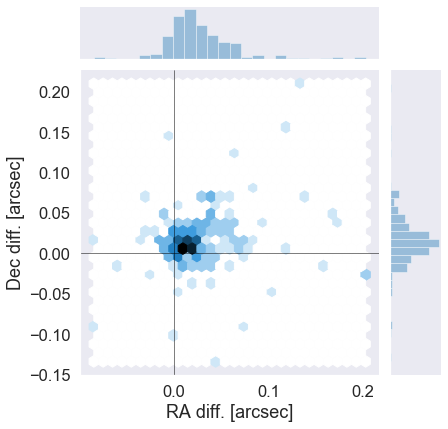

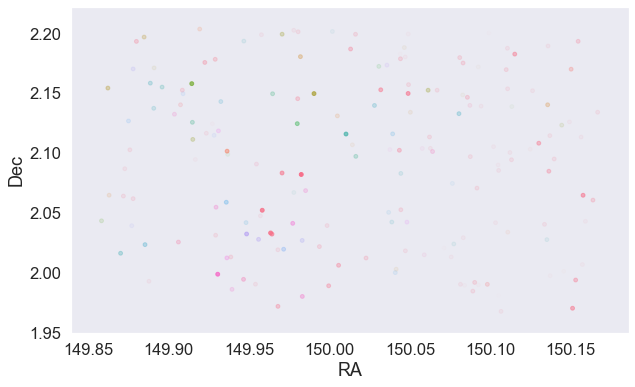

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [13]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.018899096994573483 arcsec
Dec correction: -0.01368968587449615 arcsec


In [14]:
delta_ra.to(u.deg).value

-5.249749165159301e-06

In [15]:
catalogue[RA_COL] +=  delta_ra.to(u.deg).value
catalogue[DEC_COL] += delta_dec.to(u.deg).value

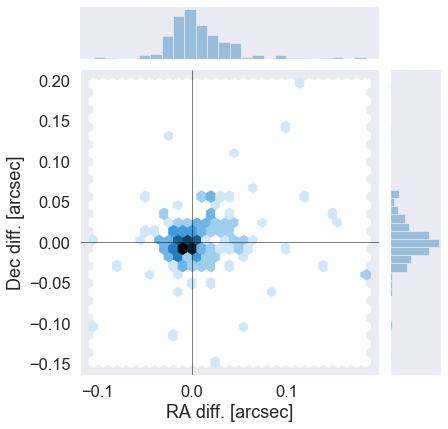

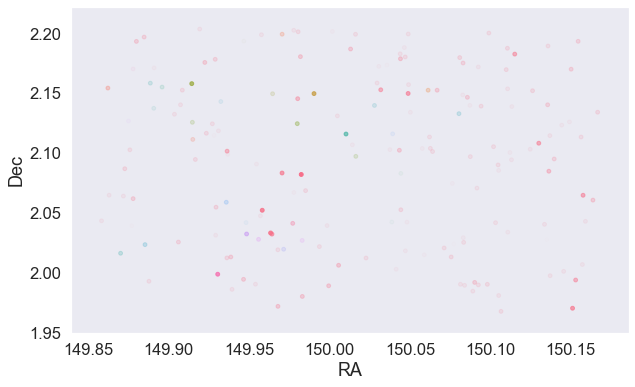

In [16]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [17]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [18]:
GAIA_FLAG_NAME = "cosmos_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

181 sources flagged.


# VI - Saving to disk

In [19]:
catalogue.write("{}/COSMOS2020_HELP.fits".format(OUT_DIR), overwrite=True)